<a href="https://colab.research.google.com/github/tjtyler/MachLearn_Perceptron/blob/main/cs472_lab_1_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron Lab





In [45]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io.arff import loadarff 

## 1. (40%) Correctly implement and submit your own code for the perceptron learning algorithm. 

### Code requirements
- Shuffle the data each epoch.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a stopping criterion: when your model has trained for a number of epochs with no significant improvement in accuracy, stop training. Note that the weights/accuracy do not usually change monotonically.
- Use your perceptron to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your perceptron on the Evaluation data with the same parameters, and print your final weights and accuracy.

In [4]:
class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, epochs, lr=.1, shuffle=True):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
            SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle
        self.epochs = epochs

    def fit(self, X, y, epochs_no_change=11, tol=0.01, initial_weights=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
            weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # make X and y internal variables in the class
        self.X = X
        self.y = y
        
        if type(initial_weights) != np.ndarray:
          self.weights = self.initialize_weights()
        else:
          self.weights = initial_weights

        cur_epoch = 0
        num_epoch_no_change = 0
        last_score = None
        while cur_epoch < self.epochs and num_epoch_no_change < epochs_no_change:
          X_bias = None
          if self.shuffle:
            self._shuffle_data(self.X, self.y)
          bias = np.ones((self.X.shape[0],1)) # bias vector of ones
          X_bias = np.concatenate((self.X,bias), axis=1) # set X = X_shuffled with bias concatenated
          for row in range(0, X_bias.shape[0]):
            net = self.calcNet(X_bias, row)
            output = self.output(net)
            delta_wts = self.deltaWts(X_bias, row, output)
            self.weights = np.add(self.weights, delta_wts)

          if cur_epoch == 0:
            last_score = self.score(self.X,self.y)
          elif cur_epoch > 0:
            cur_score = self.score(self.X,self.y)
            if ((cur_score - last_score)**2)**(1/2) < tol:
              num_epoch_no_change +=1
            else:
              num_epoch_no_change = 0
            last_score = cur_score
          cur_epoch +=1
        print('last epoch',cur_epoch)
        return self

    def calcNet(self, X, row):
      return np.dot(X[row], self.weights)

    def output(self, net):
      if net > 0:
        return 1
      else:
        return 0  

    def deltaWts(self, X, row, output):
      """
      calculates the delta_wts for the given row then returns those wts
      """
      num_cols = X.shape[1]
      delta_wts = np.zeros([self.weights.shape[0],1])
      for col in range(0, num_cols):
        delta_wts[col][0] = self.lr *(self.y[row][0] - output)*X[row][col]
      return delta_wts

    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        bias = np.ones((X.shape[0],1)) # bias vector of ones
        X_bias = np.concatenate((X,bias), axis=1) # set X = X_shuffled with bias concatenated
        predictions = np.zeros([X.shape[0],1])
        for row in range(0, X.shape[0]):
          net = self.calcNet(X_bias, row)
          output = self.output(net)
          predictions[row][0] = output
        return predictions

    def initialize_weights(self):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        num_wts = self.X.shape[1] + 1 # '+1' is for the bias
        wts = np.empty([num_wts, 1])
        for i in range(0,num_wts):
          wts[i][0] = random.uniform(0,1)
        return wts
        # return [0]

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        self._shuffle_data(X,y)
        predictions = self.predict(X)
        correct = 0
        total = y.shape[0]
        for i in range(0, y.shape[0]):
          if predictions[i][0] == y[i][0]:
            correct += 1
        return correct/total

    def _shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        single_arr = np.concatenate((X,y), axis=1) # concatenate X and y into a single array
        np.random.shuffle(single_arr) # shuffle the rows of the concatenated X-y array
        cutoff = single_arr.shape[1] - 1 # the point to split the X and y arrays after shuffling
        X = single_arr[:,:cutoff] # the shuffled X array
        y = single_arr[:,cutoff:] # the shuffled y array


    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below

Learning Rate = 0.1\
Deterministic = 10 [i.e., run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Initial Weights = All zeros

---

### 1.1.1 Debug

Debug your model by running it on the [debug dataset](https://byu.instructure.com/files/4421290/download?download_frd=1)

Expected Results:

Accuracy = [0.88]\
Final Weights = [-0.23  0.18 -0.1 ]

In [46]:

# LOAD DEBUG DATA
raw_data = loadarff('linsep2nonorigin.arff')
df_data = pd.DataFrame(raw_data[0])

# CHANGE THE VALUES OF THE ROWS OF THE 'class' COLUMN TO BE 1s AND 0s INSTEAD OF "b'1'" OR "b'0'"
df_data['class'] = df_data['class'].astype(int) 

np_arr = df_data.to_numpy() #cast dataframe to numpy array

cutoff = np_arr.shape[1] - 1 #the index to split the X and y arrays

# CUT THE numpy array INTO AN X AND y ARRAY
X = np_arr[:,:cutoff] #inputs: from 1st column to cutoff (exclusive)
y_2D = np_arr[:,cutoff:] #targets: from cutoff to last column

# SET INITIAL WEIGHTS TO ZERO
wts = np.zeros((X.shape[1]+1,1)) # weights

# TRAIN ON DEBUG DATA
perceptron = PerceptronClassifier(10, 0.1,False)

perceptron.fit(X,y_2D,initial_weights=wts)

# PRINT ACCURACY AND WEIGHTS
print('weights:\n',perceptron.get_weights().reshape((1,3))[0])
print('Accuracy = ', perceptron.score(X,y_2D))

last epoch 10
weights:
 [-0.23  0.18 -0.1 ]
Accuracy =  0.875


### 1.1.2 Evaluation

We will evaluate your model based on it's performance on the [evaluation dataset](https://byu.instructure.com/files/4421294/download?download_frd=1)

In [6]:
# LOAD DEBUG DATA
raw_data = loadarff('data_banknote_authentication.arff')
df_data = pd.DataFrame(raw_data[0])

# CHANGE THE VALUES OF THE ROWS OF THE 'class' COLUMN TO BE 1s AND 0s INSTEAD OF "b'1'" OR "b'0'"
df_data['class'] = df_data['class'].astype(int) 

np_arr = df_data.to_numpy() #cast dataframe to numpy array

cutoff = np_arr.shape[1] - 1 #the index to split the X and y arrays

# CUT THE numpy array INTO AN X AND y ARRAY
X = np_arr[:,:cutoff] #inputs: from 1st column to cutoff (exclusive)
y_2D = np_arr[:,cutoff:] #targets: from cutoff to last column

# SET INITIAL WEIGHTS TO ZERO
wts = np.zeros((X.shape[1]+1,1)) # weights

# TRAIN ON DEBUG DATA
perceptron = PerceptronClassifier(10, 0.1,False)

perceptron.fit(X,y_2D,initial_weights=wts)

# PRINT ACCURACY AND WEIGHTS
print('weights:\n',perceptron.get_weights().reshape((1,5))[0])
print('Accuracy = ', perceptron.score(X,y_2D))

last epoch 10
weights:
 [-3.80657242 -2.840821   -3.0719334  -1.4003906   4.9       ]
Accuracy =  0.9876093294460642


## 2. (30%) Classifying on linearly separable and non-linearly separable data

### 2.1 Create 2 datasets

- Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class. 
- One data set should be linearly separable and the other not.



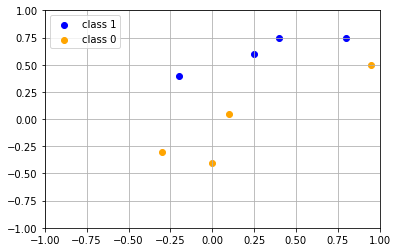

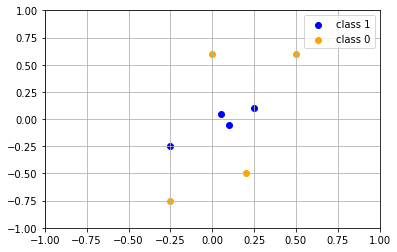

In [29]:
import matplotlib.pyplot as plt
# Create 2 datasets
# LINEARLY SEPARABLE DATA
# test = np.array([[.25,.6],[.4,.75],[-.2,.4],[.8,.75],[.95,.5],[.1,.05],[0,-.4],[-.3,-.3]])
# print('test shape:', test.shape)
lin_sep_X_1 = np.array([[.25,.6],[.4,.75],[-.2,.4],[.8,.75]])
lin_sep_X_0 = np.array([[.95,.5],[.1,.05],[0,-.4],[-.3,-.3]])
lin_sep_X = np.concatenate((lin_sep_X_1,lin_sep_X_0), axis=0)
lin_sep_y = np.array([[1],[1],[1],[1],[0],[0],[0],[0]])

# -------------lin_sep visualization testing------------------
x_coords_1 = lin_sep_X_1[:,[0]]
y_coords_1 = lin_sep_X_1[:,[1]]
x_coords_0 = lin_sep_X_0[:,[0]]
y_coords_0 = lin_sep_X_0[:,[1]]
fig, ax = plt.subplots()
ax.scatter(x_coords_1.flatten(), y_coords_1.flatten(), c='blue',label='class 1')
ax.scatter(x_coords_0.flatten(), y_coords_0.flatten(), c='orange',label='class 0')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.legend()
plt.grid()
plt.show()
# -----------------------------------------------------------

# NON-LINEARLY SEPARABLE DATA
non_lin_sep_X_1 = np.array([[-.25,-.25],[.25,.1],[.05,.05],[.1,-.05]])
non_lin_sep_X_0 = np.array([[.5,.6],[0,.6],[-.25,-.75],[.2,-.5]])
non_lin_sep_X = np.concatenate((non_lin_sep_X_1,non_lin_sep_X_0), axis=0)
non_lin_sep_y = np.array([[1],[1],[1],[1],[0],[0],[0],[0]])

# -------------non_lin_sep visualization testing------------------
x_coords2_1 = non_lin_sep_X_1[:,[0]]
y_coords2_1 = non_lin_sep_X_1[:,[1]]
x_coords2_0 = non_lin_sep_X_0[:,[0]]
y_coords2_0 = non_lin_sep_X_0[:,[1]]
fig2, ax2 = plt.subplots()
ax2.scatter(x_coords2_1.flatten(), y_coords2_1.flatten(), c='blue', label='class 1')
ax2.scatter(x_coords2_0.flatten(), y_coords2_0.flatten(), c='orange', label='class 0')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.legend()
plt.grid()
plt.show()
# -----------------------------------------------------------------


### 2.2 Train on both sets with your perceptron code (with LR=.1)

In [42]:
# Train on each dataset
# LINEARLY SEPARABLE
perceptron1 = PerceptronClassifier(10, 0.1,False)

perceptron1.fit(lin_sep_X,lin_sep_y,5)

# NON-LINEARLY SEPARABLE
perceptron2 = PerceptronClassifier(10, 0.1,False)

perceptron2.fit(non_lin_sep_X,non_lin_sep_y,5)


last epoch 10
last epoch 10


PerceptronClassifier(epochs=10, shuffle=False)

In [43]:
# PRINT ACCURACY AND WEIGHTS
print('weights:\n',perceptron1.get_weights().reshape((1,3))[0])
print('Accuracy = ', perceptron1.score(lin_sep_X,lin_sep_y))

# PRINT ACCURACY AND WEIGHTS
print('weights:\n',perceptron2.get_weights().reshape((1,3))[0])
print('Accuracy = ', perceptron2.score(non_lin_sep_X,non_lin_sep_y))

weights:
 [-0.10764617  0.5436737  -0.21576839]
Accuracy =  1.0
weights:
 [ 0.09086339 -0.0283077  -0.07325093]
Accuracy =  0.5


### 2.3 Graph the datasets and their corresponding decision line
 
 - Graph each dataset
 - Use your trained perceptrons above to determine each dataset's decision line
 - For all graphs always label the axes!
 
![Linearly Separable Data](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/linearly_separable.png)

![Not Linearly Separable](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/not_linearly_separable.png)

w1 = -0.10764616977165073
w2 = 0.5436737026331456
b = -0.21576839340522516


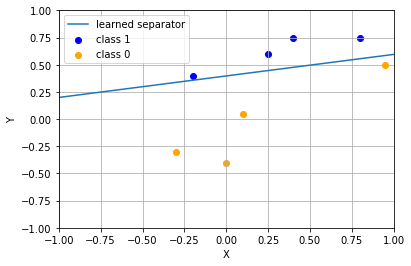

w1 = 0.09086339193422696
w2 = -0.02830769928331575
b = -0.07325093048405373


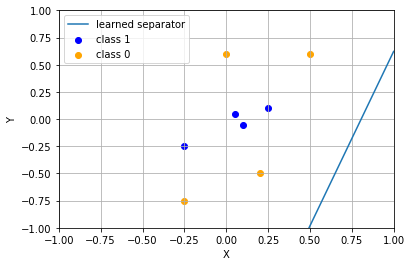

In [44]:
# Graph datasets and decision lines
#LINEARLY SEPARABLE GRAPH
w1,w2,wb = perceptron1.get_weights().reshape((1,3))[0] # w1x + w2y + wb = 0
print('w1 =',w1)
print('w2 =',w2)
print('b =',wb)
x_intercept = -wb/w1
y_intercept = -wb/w2
m = (0 - y_intercept) / (x_intercept - 0)
b = -wb/w2
x = np.linspace(-1,1,100)
y = m*x+b


x_coords_1 = lin_sep_X_1[:,[0]]
y_coords_1 = lin_sep_X_1[:,[1]]
x_coords_0 = lin_sep_X_0[:,[0]]
y_coords_0 = lin_sep_X_0[:,[1]]
fig, ax = plt.subplots()
ax.scatter(x_coords_1.flatten(), y_coords_1.flatten(), c='blue',label='class 1')
ax.scatter(x_coords_0.flatten(), y_coords_0.flatten(), c='orange',label='class 0')
plt.plot(x,y,label='learned separator')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()

# NON-LINEARLY SEPARABLE GRAPH
w1,w2,wb = perceptron2.get_weights().reshape((1,3))[0] # w1x + w2y + wb = 0
print('w1 =',w1)
print('w2 =',w2)
print('b =',wb)
x_intercept = -wb/w1
y_intercept = -wb/w2
m = (0 - y_intercept) / (x_intercept - 0)
b = -wb/w2
x = np.linspace(-1,1,100)
y = m*x+b

x_coords2_1 = non_lin_sep_X_1[:,[0]]
y_coords2_1 = non_lin_sep_X_1[:,[1]]
x_coords2_0 = non_lin_sep_X_0[:,[0]]
y_coords2_0 = non_lin_sep_X_0[:,[1]]
fig2, ax2 = plt.subplots()
ax2.scatter(x_coords2_1.flatten(), y_coords2_1.flatten(), c='blue', label='class 1')
ax2.scatter(x_coords2_0.flatten(), y_coords2_0.flatten(), c='orange', label='class 0')
plt.plot(x,y, label='learned separator')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.show()

### 2.4 Discuss why the perceptron won’t converge on non-linearly separable data.

The perceptron won't converge on non-linearly separable data because if the data is not linearly separable that means that a line or hyperplane can't be drawn through it that will separate the two classes from one another. Mathematcially what is happening is because the data is not linearly separable the weights never converge on values.

## 3. (20%) Use your perceptron code to learn this version of the [voting data set](https://byu.instructure.com/files/4421311/download?download_frd=1).

This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.  

### 3.1 Create a table that reports the final training and test set accuracy and the number of epochs for each trial.

- Try it five times with different random 70/30 splits. 
- Use your own code to randomize and make splits. 
- Report the 5 trials and the average across the 5 trials in a table.  

| Trial | Training Accuracy | Test accuracy | Number of epochs |
| --- | --- | --- | --- |
| 1 | .95 | .55 | 4 |
| 2 | .85 | .45 | 6 |
| Average | .9 | .5 | 5 | 

*- As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.*


In [69]:
def seventyThirtySplit(arr):
  """
  the 'arr' arguement should be the full numpy array before it is split into X and y
  """
  rand_start_index = random.randint(0,arr.shape[0]-1)
  num_vals_70 = round((arr.shape[0])*.7)
  num_vals_30 = arr.shape[0] - num_vals_70
  arr_70_combined = None
  arr_30 = None
  if (rand_start_index + num_vals_70) >= arr.shape[0]: # if the starting index (row) + the number of rows we need to make 70% of the rows >= the number of rows in arr
    num_vals_from_start = (rand_start_index + num_vals_70) - arr.shape[0] - 1 # the number of rows past the last row (back to the first row) that we need to make 70%
    arr_70_pt1 = arr[:num_vals_from_start,:] # part1 of the 70%_array from row[0] to row[num_vals_from_start - 1]
    arr_70_pt2 = arr[rand_start_index:,:] # part2 of the 70%_array from the rand_start_index (row) to the last index (row)
    arr_70_combined = np.concatenate((arr_70_pt1,arr_70_pt2), axis=0)
    arr_30 = arr[num_vals_from_start:rand_start_index,:] # 30%_array is everything in between
  else:
    arr_70_combined = arr[rand_start_index:num_vals_70,:]
    arr_30 = arr[num_vals_70:,:]
  return arr_70_combined, arr_30


In [70]:
# Create the table any way you like
raw_data = loadarff('voting-dataset.arff')
df_data = pd.DataFrame(raw_data[0])

np_arr = df_data.to_numpy() #cast dataframe to numpy array

# SET 'y' AND 'republican' TO 1 AND 'n' AND 'democrat' TO 0
np_arr[np_arr == b'y'] = 1 
np_arr[np_arr == b'republican'] = 1 
np_arr[np_arr == b'n'] = 0 
np_arr[np_arr == b'democrat'] = 0 

# SEPARATE np_arr INTO 'training_arr' (70%) AND 'test_arr' (30%)
training_arr, test_arr = seventyThirtySplit(np_arr)

cutoff = np_arr.shape[1] - 1 #the index to split the X and y arrays

# CUT THE 'training_arr'AND 'test_arr' arrays INTO X AND y ARRAYS
train_X = training_arr[:,:cutoff] #inputs: from 1st column to cutoff (exclusive)
train_y = training_arr[:,cutoff:] #targets: from cutoff to last column
test_X = test_arr[:,:cutoff]
test_y = test_arr[:,cutoff:]

(322, 17)
(139, 17)


### 3.2 By looking at the weights, explain what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical? 


*Explanation goes here*

### 3.3 Make a graph of the average misclassification rate vs epochs (0th – final epoch).

- Average the misclassification rate for the training set across your 5 trials (not across 5 epochs).


![Average Misclassification Rate](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/avg_misclassification_rate_vs_epochs.png)

In [ ]:
# Graph here
    
def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassification Rate")
    plt.show()
    


## 4.1 (5%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn the voting task above.
- Report and compare your results with your own perceptron code.

In [ ]:
# Load sklearn perceptron

# Train on voting dataset

*Report your comparison*

## 4.2 (5%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn one other data set of your choice.
- Try out some of the hyper-parameters that scikit-learn makes available.

In [ ]:
# Load sklearn perceptron

# Train on your dataset

*Report what hyperparameters you experimented with & what performed well*

## 5. (Optional 5% extra credit) Use the perceptron rule to learn the [iris task](https://byu.instructure.com/files/4421369/download?download_frd=1) or some other task with more than two possible output values. 

Note that the [iris data](https://byu.instructure.com/files/4421369/download?download_frd=1) set has 3 output classes, and a perceptron node only has two possible outputs.  You could implement either of the two most common ways to deal with this. For testing you just execute the novel instance on each model and combine the overall results to see which output class wins.